In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd

import os
import numpy as np
import torch
from models import Generator, Discriminator
from layers import TacotronSTFT
from audio_processing import griffin_lim
from utils import load_wav_to_torch
from plotting_utils import reshape_to_matrix

MAX_WAV_VALUE = 32768.0
BATCH_SIZE = 32
SAMPLING_RATE = 16000
SPEAKER_ID = 101

plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 1064, in start


In [2]:
torch.no_grad()

In [3]:
def load_checkpoint(checkpoint_path, G_net):
    assert os.path.isfile(checkpoint_path)
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    G_net.load_state_dict(checkpoint_dict['G_net'])
    print("Loaded checkpoint '{}'" .format(checkpoint_path))
    return G_net

In [3]:
def mel2spectrogram(mel, stft, C=1e4, spec_from_mel_scaling=1000):
    mel_decompress = stft.spectral_de_normalize(mel.unsqueeze(0))
    mel_decompress = mel_decompress / C
    mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
    spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
    spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
    return spec_from_mel

In [4]:
taco_stft = TacotronSTFT(
    filter_length=1024, hop_length=160,
    win_length=1024, sampling_rate=16000, n_mel_channels=64,
    mel_fmin=0, mel_fmax=None, representation='asrgen')

In [67]:
checkpoint_path = '/home/adlr_video_prediction.cosmos361/tts/runs/asrgen/speaker101/run_0_val_test/checkpoint_dcgan_speaker101_beta1.0_clr0.0001_grl0.0001_1000'
checkpoint_path = '/home/adlr_video_prediction.cosmos361/tts/runs/asrgen/speaker101/run_0_noother/checkpoint_dcgan_speaker101_beta0_clr0.0001_grl0.0001_3000'

In [68]:
checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
G_net = Generator(64)
G_net.load_state_dict(checkpoint_dict['G_net'])

In [69]:
noise = torch.autograd.Variable(torch.randn(BATCH_SIZE, 128))
samples = G_net(noise)

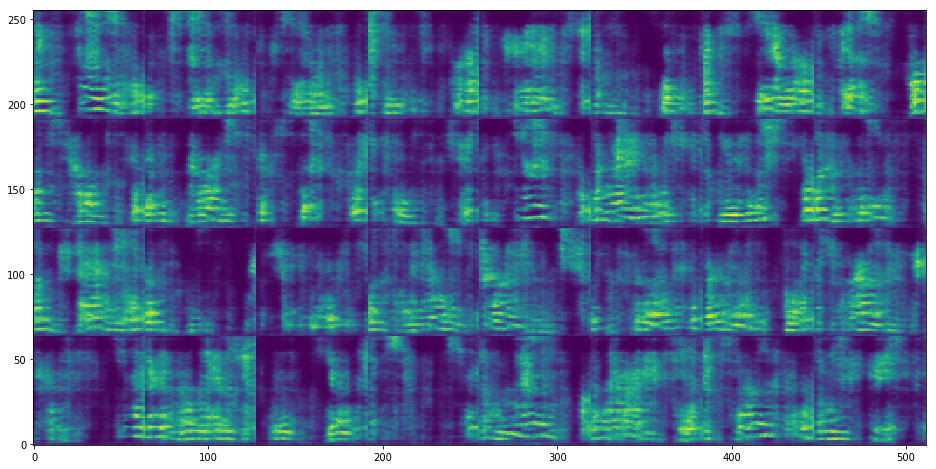

In [70]:
samples_reshape = reshape_to_matrix(samples.data.cpu().numpy(), 4, 8)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(samples_reshape, origin='bottom', aspect='auto')

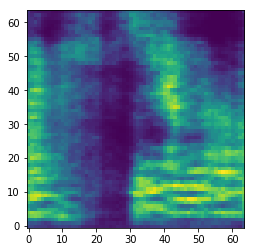

In [71]:
mel = samples[np.random.randint(samples.size(0))]
plt.imshow(mel.data.cpu().numpy(), origin='bottom')

In [72]:
# scale to the range of a real mel
audio = load_wav_to_torch('data_16khz/zljs/ljs.wav', SAMPLING_RATE)
audio /= MAX_WAV_VALUE
audio = audio[None, :]
reference_mel = taco_stft.mel_spectrogram(audio)[0]
print(reference_mel.min(), reference_mel.max())

(tensor(1.00000e-02 *
       1.4658), tensor(8.9875))


In [73]:
mel -= mel.min()
mel = mel / mel.max()
mel = mel * reference_mel.max()
print(mel.min(), mel.max())

(tensor(0.), tensor(8.9875))


In [74]:
rand_start = np.random.randint(reference_mel.size(-1) - 64)
reference_mel_patch = reference_mel[:, rand_start:rand_start+64].cpu()

In [75]:
C = 1e4
spec_from_mel = mel2spectrogram(mel, taco_stft, C)
spec_from_mel_ref = mel2spectrogram(reference_mel_patch, taco_stft, C)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Text(0.5,1,'Real Spectrogram')

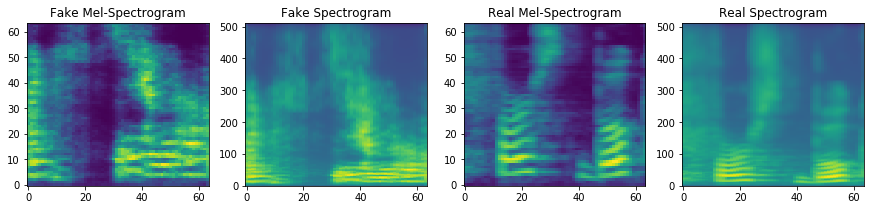

In [76]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
axes[0].imshow(mel.data.cpu().numpy(), aspect='auto', origin='bottom', interpolation='none')
axes[1].imshow(np.log(spec_from_mel[0].numpy()), aspect='auto', origin='bottom', interpolation='none')
axes[2].imshow(reference_mel_patch.numpy(), aspect='auto', origin='bottom', interpolation='none')
axes[3].imshow(np.log(spec_from_mel_ref[0].numpy()), aspect='auto', origin='bottom', interpolation='none')
axes[0].set_title("Fake Mel-Spectrogram")
axes[1].set_title("Fake Spectrogram")
axes[2].set_title("Real Mel-Spectrogram")
axes[3].set_title("Real Spectrogram")

In [77]:
# Fake Griffin-Lim synthesis
waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), taco_stft.stft_fn, 30)
waveform = waveform / waveform.abs().max()
ipd.Audio(waveform[0].data.cpu().numpy(), rate=SAMPLING_RATE) 

In [78]:
# Real Griffin-Lim synthesis
waveform_ref = griffin_lim(torch.autograd.Variable(spec_from_mel_ref[:, :, :-1]), taco_stft.stft_fn, 30)
ipd.Audio(waveform_ref[0].data.cpu().numpy(), rate=SAMPLING_RATE) 